In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_dir = "F:\Work\Traditional Food Classification"
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    file_path = os.path.join(data_dir, fold)
    if not os.path.isdir(file_path):
        continue
    fpath = os.listdir(file_path)
    
    for f in fpath:
        fil_path=os.path.join(file_path,f)
        filepaths.append(fil_path)
        labels.append(fold)

f_series=pd.Series(filepaths,name='filepaths')
l_series=pd.Series(labels,name='labels')
df=pd.concat([f_series, l_series], axis= 1)

In [3]:
df

,filepaths,labels
0,F:\Work\Traditional Food Classification\Birian...,Biriani
1,F:\Work\Traditional Food Classification\Birian...,Biriani
2,F:\Work\Traditional Food Classification\Birian...,Biriani
3,F:\Work\Traditional Food Classification\Birian...,Biriani
4,F:\Work\Traditional Food Classification\Birian...,Biriani
...,...,...
1085,F:\Work\Traditional Food Classification\Roshog...,Roshogolla
1086,F:\Work\Traditional Food Classification\Roshog...,Roshogolla
1087,F:\Work\Traditional Food Classification\Roshog...,Roshogolla
1088,F:\Work\Traditional Food Classification\Roshog...,Roshogolla


In [4]:
# train dataframe  80% train  20% dummy
train_df, dummy_df = train_test_split(df,  test_size= 0.2, shuffle= True, random_state= 43)

# valid and test dataframe 10% validate  10% test
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 43)

In [6]:
# create image generator
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()

ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 872 validated image filenames belonging to 7 classes.
Found 109 validated image filenames belonging to 7 classes.
Found 108 validated image filenames belonging to 7 classes.


In [ ]:
# First Tuned Pre-Trained model: EfficientNetB3

In [7]:
# Define input image dimensions
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Define number of classes

# Define the input layer
inputs = tf.keras.Input(shape=img_shape)

# Load the pre-trained EfficientNetB3 model without the top layer
base_model = keras.applications.EfficientNetB3(include_top=False, weights="imagenet", 
input_tensor=inputs)

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling to match the target shape
x = BatchNormalization(momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
outputs = Dense(class_count, activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 40)      │           1,080 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 40)      │             160 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 40)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 40)      │             360 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 40)      │             160 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 40)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 40)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 40)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 10)          │             410 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 40)          │             440 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 11,184,950 (42.67 MB)

 Trainable params: 398,343 (1.52 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [9]:
# Define callbacks for early stopping and model checkpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model with frozen layers
history1 = model.fit(train_gen, epochs=10, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4777 - loss: 19.4542 - val_accuracy: 0.7798 - val_loss: 9.7663
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8078 - loss: 13.8228 - val_accuracy: 0.7798 - val_loss: 8.1129
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8258 - loss: 10.0784 - val_accuracy: 0.7339 - val_loss: 7.2464
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8726 - loss: 7.7447 - val_accuracy: 0.6514 - val_loss: 6.7843
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8320 - loss: 6.8487 - val_accuracy: 0.6697 - val_loss: 6.3846
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8698 - loss: 6.3091 - val_accuracy: 0.7339 - val_loss: 6.0017
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8644 - loss: 5.8713 - val_accuracy: 0.7890 - val_loss: 5.6208
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8644 - loss: 5.4973 - val_accuracy: 0.8624 - val_lo

In [10]:
# Make predictions on the test data
test_gen.reset()  # Ensure the generator is reset to avoid data shuffling issues
predictions = model.predict(test_gen, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes  # True labels

# Get class indices and map them to class names
class_indices = {v: k for k, v in test_gen.class_indices.items()}
y_true_labels = [class_indices[label] for label in y_true]
y_pred_labels = [class_indices[label] for label in y_pred]

# Classification report
report = classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys()), digits=4)
print("Classification Report:\n", report)

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
Classification Report:
               precision    recall  f1-score   support

     Biriani     0.9474    0.9000    0.9231        20
   Dim bhuna     1.0000    1.0000    1.0000        13
 Panta Ilish     1.0000    0.5000    0.6667         8
  Roshogolla     1.0000    1.0000    1.0000        18
      fuchka     1.0000    0.7917    0.8837        24
   kala vuna     1.0000    1.0000    1.0000         9
    khichuri     0.6154    1.0000    0.7619        16

    accuracy                         0.8981       108
   macro avg     0.9375    0.8845    0.8908       108
weighted avg     0.9333    0.8981    0.9000       108



In [11]:
# Compute metrics
conf_matrix = confusion_matrix(y_true, y_pred)
tp = np.diag(conf_matrix)
sensitivity = tp / np.sum(conf_matrix, axis=1)
sensitivity = np.nan_to_num(sensitivity)  # Handle any NaNs

In [13]:
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[18  0  0  0  0  0  2]
 [ 0 13  0  0  0  0  0]
 [ 0  0  4  0  0  0  4]
 [ 0  0  0 18  0  0  0]
 [ 1  0  0  0 19  0  4]
 [ 0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0 16]]


In [14]:
print("sensitivity:")
print(sensitivity)

sensitivity:
[0.9        1.         0.5        1.         0.79166667 1.
 1.        ]


In [15]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

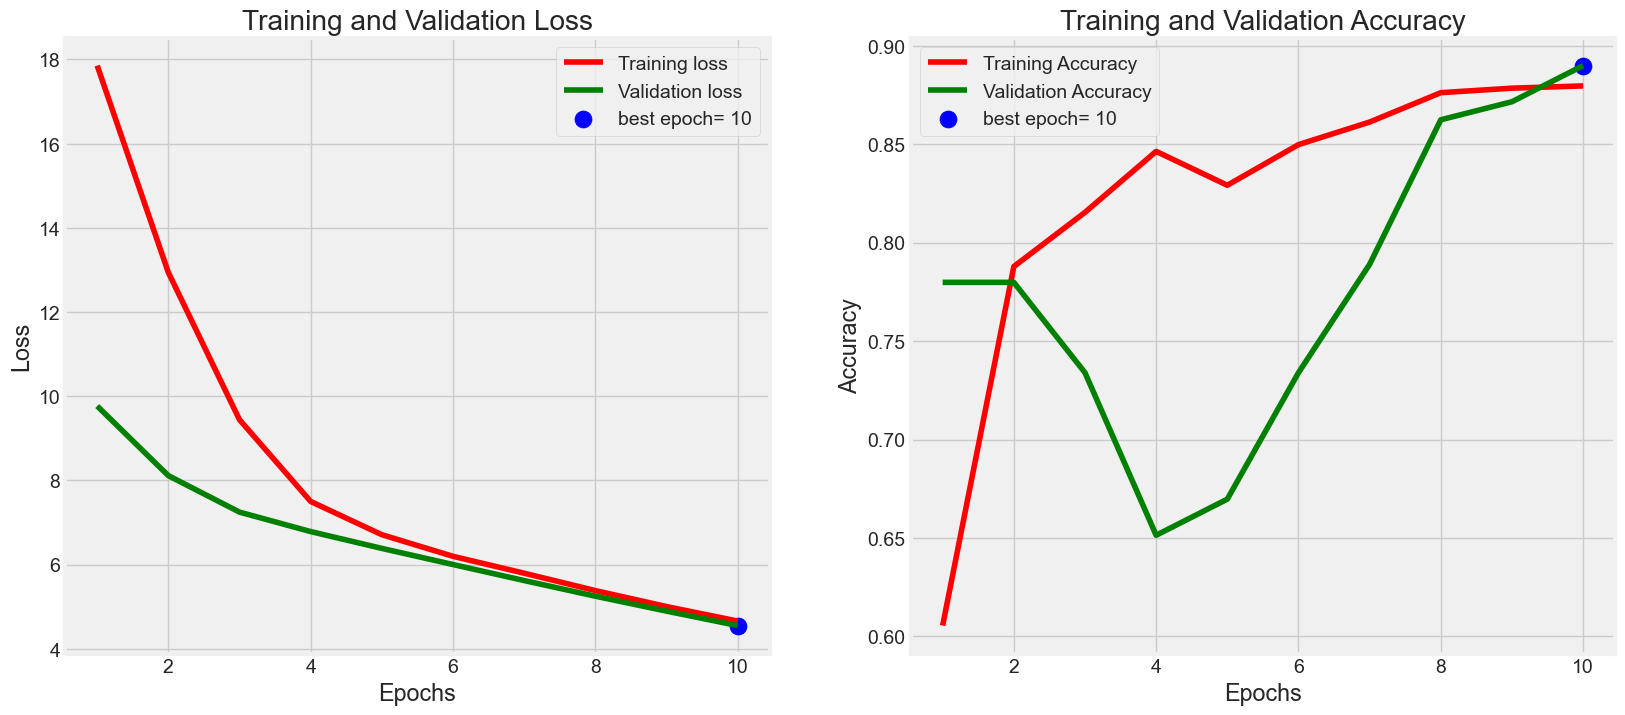

In [16]:
plot_training(history1)

In [ ]:
# Second Tuned Pre-Trained model:ResNet50

In [17]:
# Define input image dimensions
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Define number of classes

# Define the input layer
inputs = tf.keras.Input(shape=img_shape)

# Load the pre-trained EfficientNetB3 model without the top layer
base_model = keras.applications.ResNet50(include_top=False, weights="imagenet", 
input_tensor=inputs)

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling to match the target shape
x = BatchNormalization(momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
outputs = Dense(class_count, activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,122,247 (92.02 MB)

 Trainable params: 530,439 (2.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [19]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]
history2 = model.fit(train_gen, epochs=10, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.3947 - loss: 20.3962 - val_accuracy: 0.6239 - val_loss: 14.7354
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.7852 - loss: 13.8500 - val_accuracy: 0.7523 - val_loss: 10.5526
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8639 - loss: 9.9656 - val_accuracy: 0.7431 - val_loss: 8.4539
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8868 - loss: 7.9828 - val_accuracy: 0.7615 - val_loss: 7.6253
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.8931 - loss: 7.1974 - val_accuracy: 0.7431 - val_loss: 7.1285
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8869 - loss: 6.6933 - val_accuracy: 0.7615 - val_loss: 6.7274
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8941 - loss: 6.2506 - val_accuracy: 0.7890 - val_loss: 6.3203
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8817 - loss: 5.8805 - val_accuracy: 0.8073 - val_

In [20]:
# Make predictions on the test data
test_gen.reset()  # Ensure the generator is reset to avoid data shuffling issues
predictions = model.predict(test_gen, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes  # True labels

# Get class indices and map them to class names
class_indices = {v: k for k, v in test_gen.class_indices.items()}
y_true_labels = [class_indices[label] for label in y_true]
y_pred_labels = [class_indices[label] for label in y_pred]

# Classification report
report = classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys()), digits=4)
print("Classification Report:\n", report)

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step  
Classification Report:
               precision    recall  f1-score   support

     Biriani     0.8235    0.7000    0.7568        20
   Dim bhuna     0.9231    0.9231    0.9231        13
 Panta Ilish     1.0000    0.3750    0.5455         8
  Roshogolla     0.9000    1.0000    0.9474        18
      fuchka     0.8182    0.7500    0.7826        24
   kala vuna     0.7778    0.7778    0.7778         9
    khichuri     0.5833    0.8750    0.7000        16

    accuracy                         0.7963       108
   macro avg     0.8323    0.7716    0.7761       108
weighted avg     0.8207    0.7963    0.7920       108



In [21]:
# Compute metrics
conf_matrix = confusion_matrix(y_true, y_pred)
tp = np.diag(conf_matrix)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[14  0  0  1  2  1  2]
 [ 0 12  0  0  0  0  1]
 [ 1  0  3  0  1  0  3]
 [ 0  0  0 18  0  0  0]
 [ 1  1  0  1 18  1  2]
 [ 0  0  0  0  0  7  2]
 [ 1  0  0  0  1  0 14]]


In [22]:
sensitivity = tp / np.sum(conf_matrix, axis=1)
sensitivity = np.nan_to_num(sensitivity)  # Handle any NaNs
print(sensitivity)

[0.7        0.92307692 0.375      1.         0.75       0.77777778
 0.875     ]


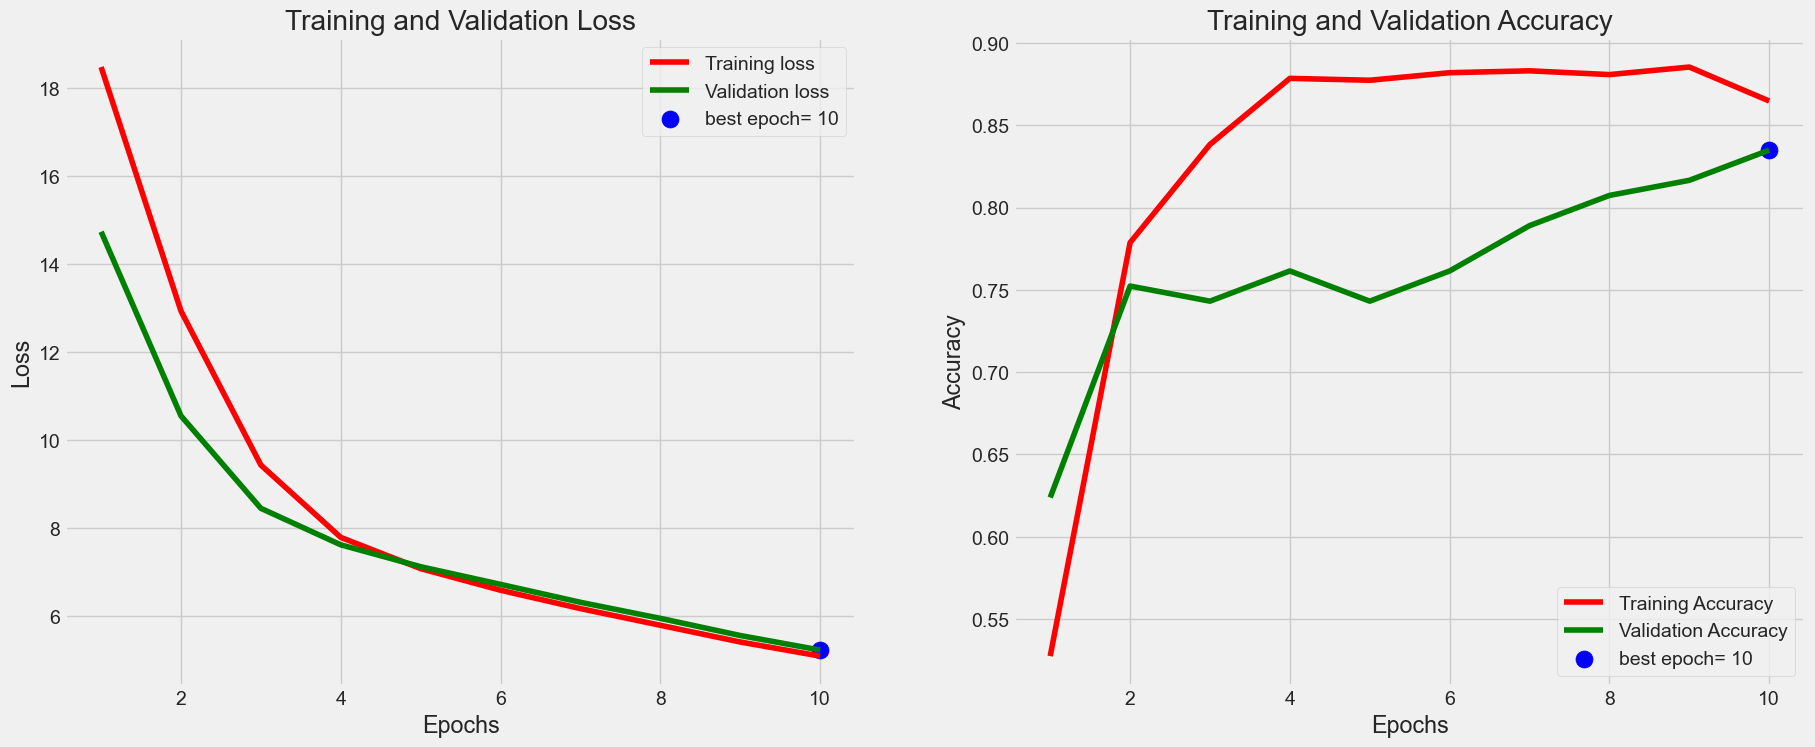

In [23]:
plot_training(history2)

In [ ]:
# Third Tuned Pre-Trained model: VGG16

In [24]:
# Define input image dimensions
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Define number of classes

# Define the input layer
inputs = tf.keras.Input(shape=img_shape)

# Load the pre-trained InceptionV3 model without the top layer
base_model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization(momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
outputs = Dense(class_count, activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,0

 Total params: 14,849,863 (56.65 MB)

 Trainable params: 134,151 (524.03 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [26]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]
history3 = model.fit(train_gen, epochs=10, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.2761 - loss: 17.7535 - val_accuracy: 0.5321 - val_loss: 19.4406
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.5620 - loss: 13.4284 - val_accuracy: 0.6606 - val_loss: 13.5851
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.6704 - loss: 10.7388 - val_accuracy: 0.6330 - val_loss: 10.1481
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.7011 - loss: 8.3847 - val_accuracy: 0.6789 - val_loss: 7.8575
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.7364 - loss: 6.7348 - val_accuracy: 0.6697 - val_loss: 6.5998
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.7380 - loss: 5.8273 - val_accuracy: 0.6239 - val_loss: 5.8866
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.7440 - loss: 5.3743 - val_accuracy: 0.5963 - val_loss: 5.4339
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.7141 - loss: 4.9994 - val_accuracy: 0.5872 - va

In [27]:
# Make predictions on the test data
test_gen.reset()  # Ensure the generator is reset to avoid data shuffling issues
predictions = model.predict(test_gen, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes  # True labels

# Get class indices and map them to class names
class_indices = {v: k for k, v in test_gen.class_indices.items()}
y_true_labels = [class_indices[label] for label in y_true]
y_pred_labels = [class_indices[label] for label in y_pred]

# Classification report
report = classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys()), digits=4)
print("Classification Report:\n", report)

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step 
Classification Report:
               precision    recall  f1-score   support

     Biriani     0.8667    0.6500    0.7429        20
   Dim bhuna     1.0000    0.6154    0.7619        13
 Panta Ilish     1.0000    0.2500    0.4000         8
  Roshogolla     0.9000    1.0000    0.9474        18
      fuchka     0.8095    0.7083    0.7556        24
   kala vuna     0.8750    0.7778    0.8235         9
    khichuri     0.4118    0.8750    0.5600        16

    accuracy                         0.7315       108
   macro avg     0.8376    0.6966    0.7130       108
weighted avg     0.8188    0.7315    0.7363       108



In [28]:
# Compute metrics
conf_matrix = confusion_matrix(y_true, y_pred)
tp = np.diag(conf_matrix)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[13  0  0  0  1  0  6]
 [ 1  8  0  0  1  0  3]
 [ 1  0  2  0  1  0  4]
 [ 0  0  0 18  0  0  0]
 [ 0  0  0  2 17  0  5]
 [ 0  0  0  0  0  7  2]
 [ 0  0  0  0  1  1 14]]


In [29]:
sensitivity = tp / np.sum(conf_matrix, axis=1)
sensitivity = np.nan_to_num(sensitivity)  # Handle any NaNs
print(sensitivity)

[0.65       0.61538462 0.25       1.         0.70833333 0.77777778
 0.875     ]


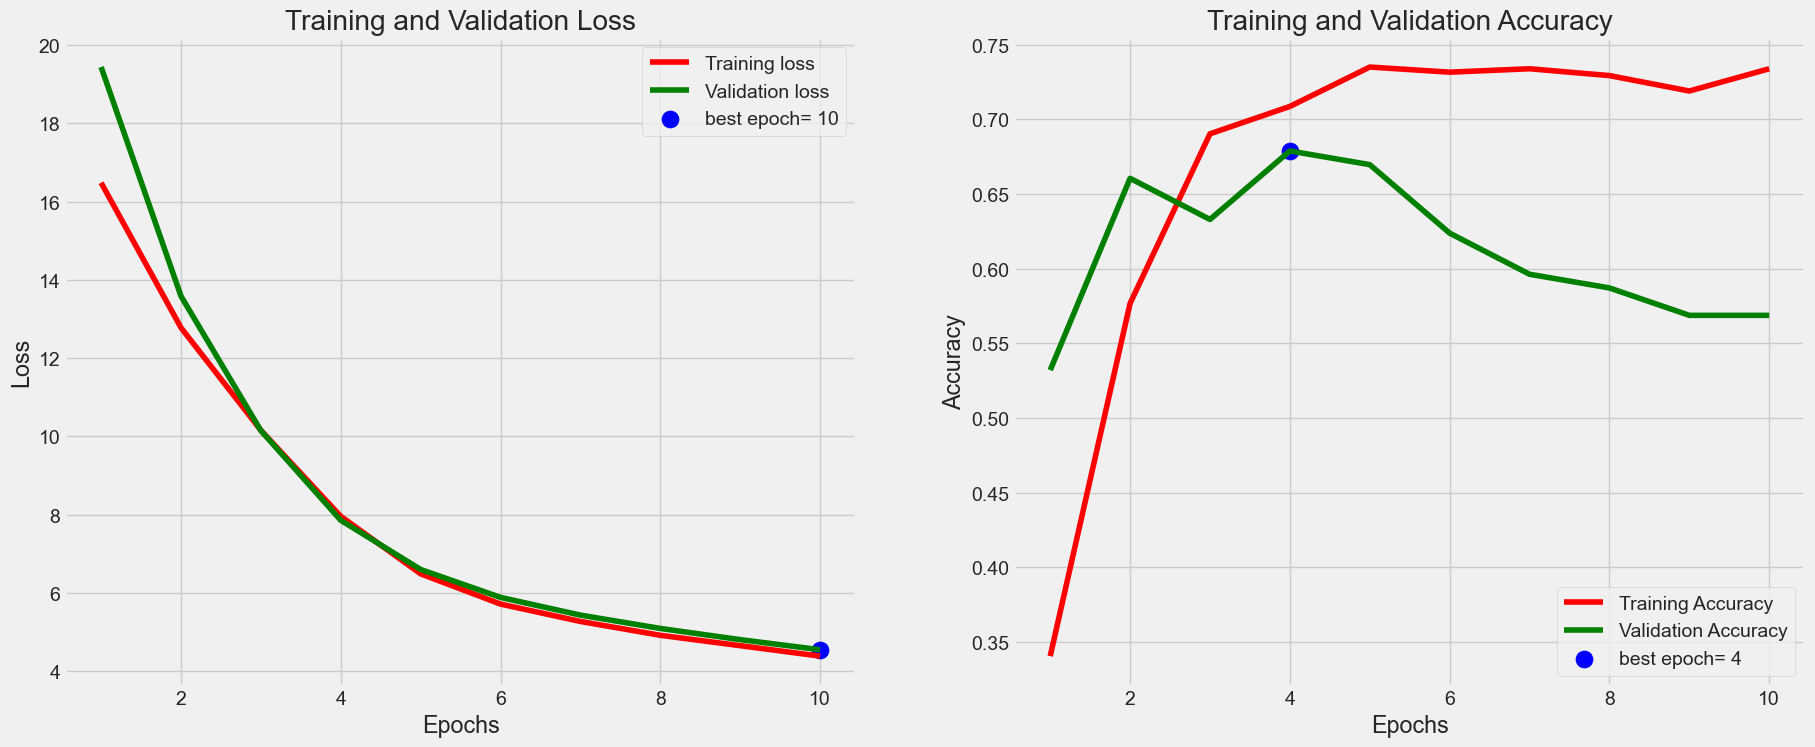

In [30]:
plot_training(history3)